# Introduction

This dataset is from kaggle and as such all rights belong to the authors. While the original goal of this project is to determine future house price projections, the true purpose is to practice and get familiar with a wide variety of data science tools and techniques.

For this project we will use two commonly used machine learning techniques: linear regression and random forest. We choose this because they are widely used and relatively straightforward. There might be more suitable models but we will explore those in the future. 

The topics related to this project includes:
- normalizing data
- handling missing values
- linear regression
- random forest
- training and testing models
- cross validating our models

Below are the table of contents:
1. Overview of dataset
2. Fill in missing data
3. Determine relevant variables
4. Filter data
5. Normalize data
6. Training and validating models
7. Testing models
8. Projection

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from scipy import stats
import statsmodels.regression as smreg
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 1. Overview of dataset

First lets take look at the data set we have. Open the training data set in the csv file. 

In [7]:
df_train = pd.read_csv("resources/train.csv")
display(df_train)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


We can also save it as an excel file for readability in offline. For this you need to install the module 'openpyxl' with pip

In [8]:
# df_train.to_excel("resources/train.xlsx", index=False)

As shown above there are in total 79 explanatory variables but not all of them are relevant and some have quite a lot of missing data. Let's get a general idea of what the biggest explanatory variables can be by creating a correlation heat map

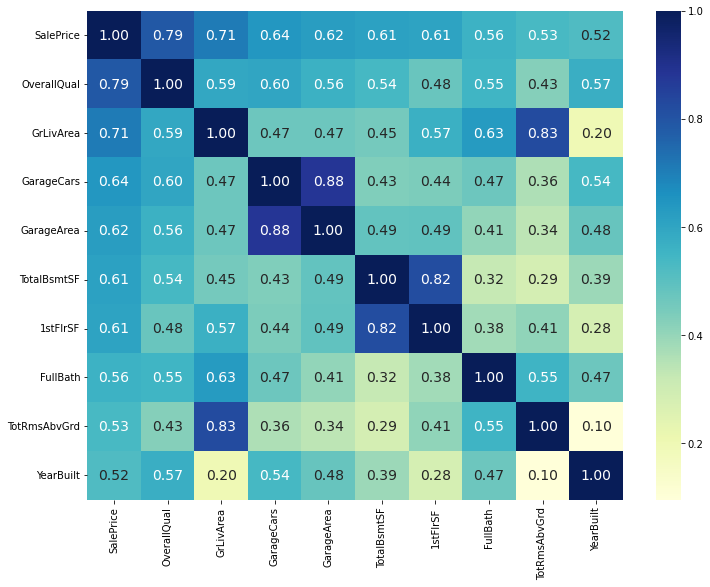

In [9]:
#correlation matrix
corrmat = df_train.corr()
fig, ax = plt.subplots(figsize=(12, 9))
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
hm = sns.heatmap(cm, cbar=True, cmap="YlGnBu", annot=True, fmt='.2f', annot_kws={'size': 14}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Based on the correlation heat map, we see that variables related to areas are the most contributors to sale price. Variables like 'GarageCars' or 'FullBath' indirectly indicates area. Therefore, it is safe to assume that we should pay attention to variables that indicate area.

Let's also see the distribution function of sale price

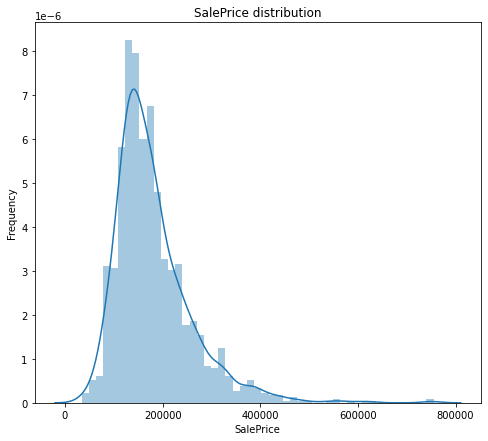

In [10]:
fig, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(df_train['SalePrice']);
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
plt.show()

With the exception of a few outliers, it has almost a normal distribution shape which is good for us.

## 2. Fill in missing data

Some of the variables have missing data. Let's first determine the variables with the most missing data by calculate the percentage. 

In [11]:
total = df_train.isnull().sum()
percent = (100 * total/len(df_train.index)).sort_values(ascending=False)
display(percent.head(20))

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
Id               0.000000
dtype: float64

We can either drop the columns or perform imputation, which is replacing missing data with a certain value. We drop a variable when:
- More than 15% of the data is missing
- It is likely to be an outlier
- It is a sub-variables of another main variable

The columns 'PoolQC' all the way to 'LotFrontage' have more than 15% data missing thus they can be dropped.

In [12]:
df_train.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage'], 
        inplace=True)

Looking closely at the variables, we see that GarageArea tends to be the dominant variable amongst other garage related variables. Therefore we can drop all the garage related variables except for GarageArea. We can apply the same logic to basement related variables.

In [13]:
df_train.drop(columns=['GarageYrBlt', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageCars', 'BsmtFinType2', 
                 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'], inplace=True)

Later on, we won't be needing the bottom three variables as well but for the sake of learning, we will perform imputation. 'MasVnrArea' has integer data type while 'Electrical' and 'MasVnrType' have strings. Therefore the imputation for 'MasVnrArea' will be the mean while the other two will be most frequent string value

In [14]:
# Imputation for integer
si = SimpleImputer(missing_values=np.nan, strategy='mean')
si.fit(df_train[['MasVnrArea']])
df_train['MasVnrArea'] = si.transform(df_train[['MasVnrArea']])

# Imputation for string
si=SimpleImputer(missing_values=np.nan, strategy='most_frequent')
si.fit(df_train[['Electrical']])
df_train['Electrical'] = si.transform(df_train[['Electrical']])
si.fit(df_train[['MasVnrType']])
df_train['MasVnrType'] = si.transform(df_train[['MasVnrType']])

## 3. Determine relevant variables

Now that we have dropped some irrelevant variables let us create the correlation heatmap again.

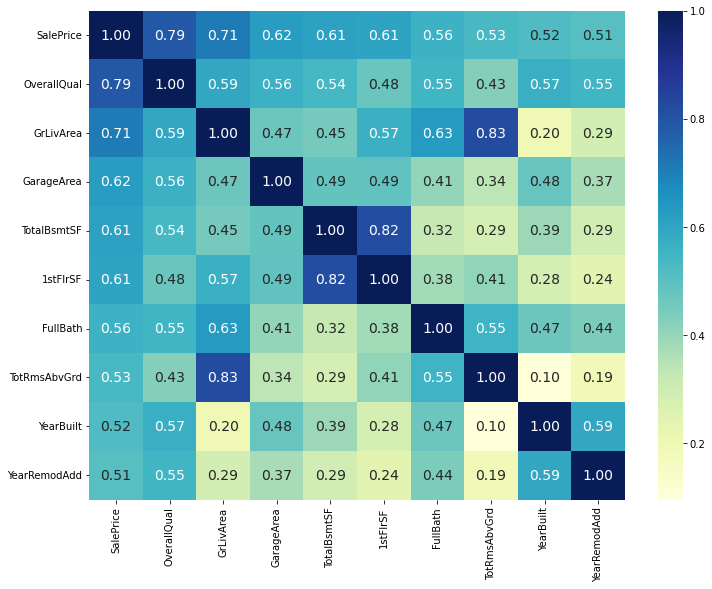

In [15]:
#correlation matrix
corrmat = df_train.corr()
fig, ax = plt.subplots(figsize=(12, 9))
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
hm = sns.heatmap(cm, cbar=True, cmap="YlGnBu", annot=True, fmt='.2f', annot_kws={'size': 14}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Based on the above graph the following variables are candidates for our model:
- OverallQual: Rates the overall material and finish of the house
- GrLivingArea: Above ground living area in square feat
- GarageArea: Size of garage in square feet
- TotalBsmtSF: Total square feet of basement area
- 1stFlrSF: First Floor square feet
- FullBath: Full bathrooms above grade
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
- YearBuilt: Original construction date
- YearRemodAdd: Remodel date. If never remodeled same as built date

But 9 explanatory variables still seem too many. Let's see each of their scatter plot in correlation to the sale price:

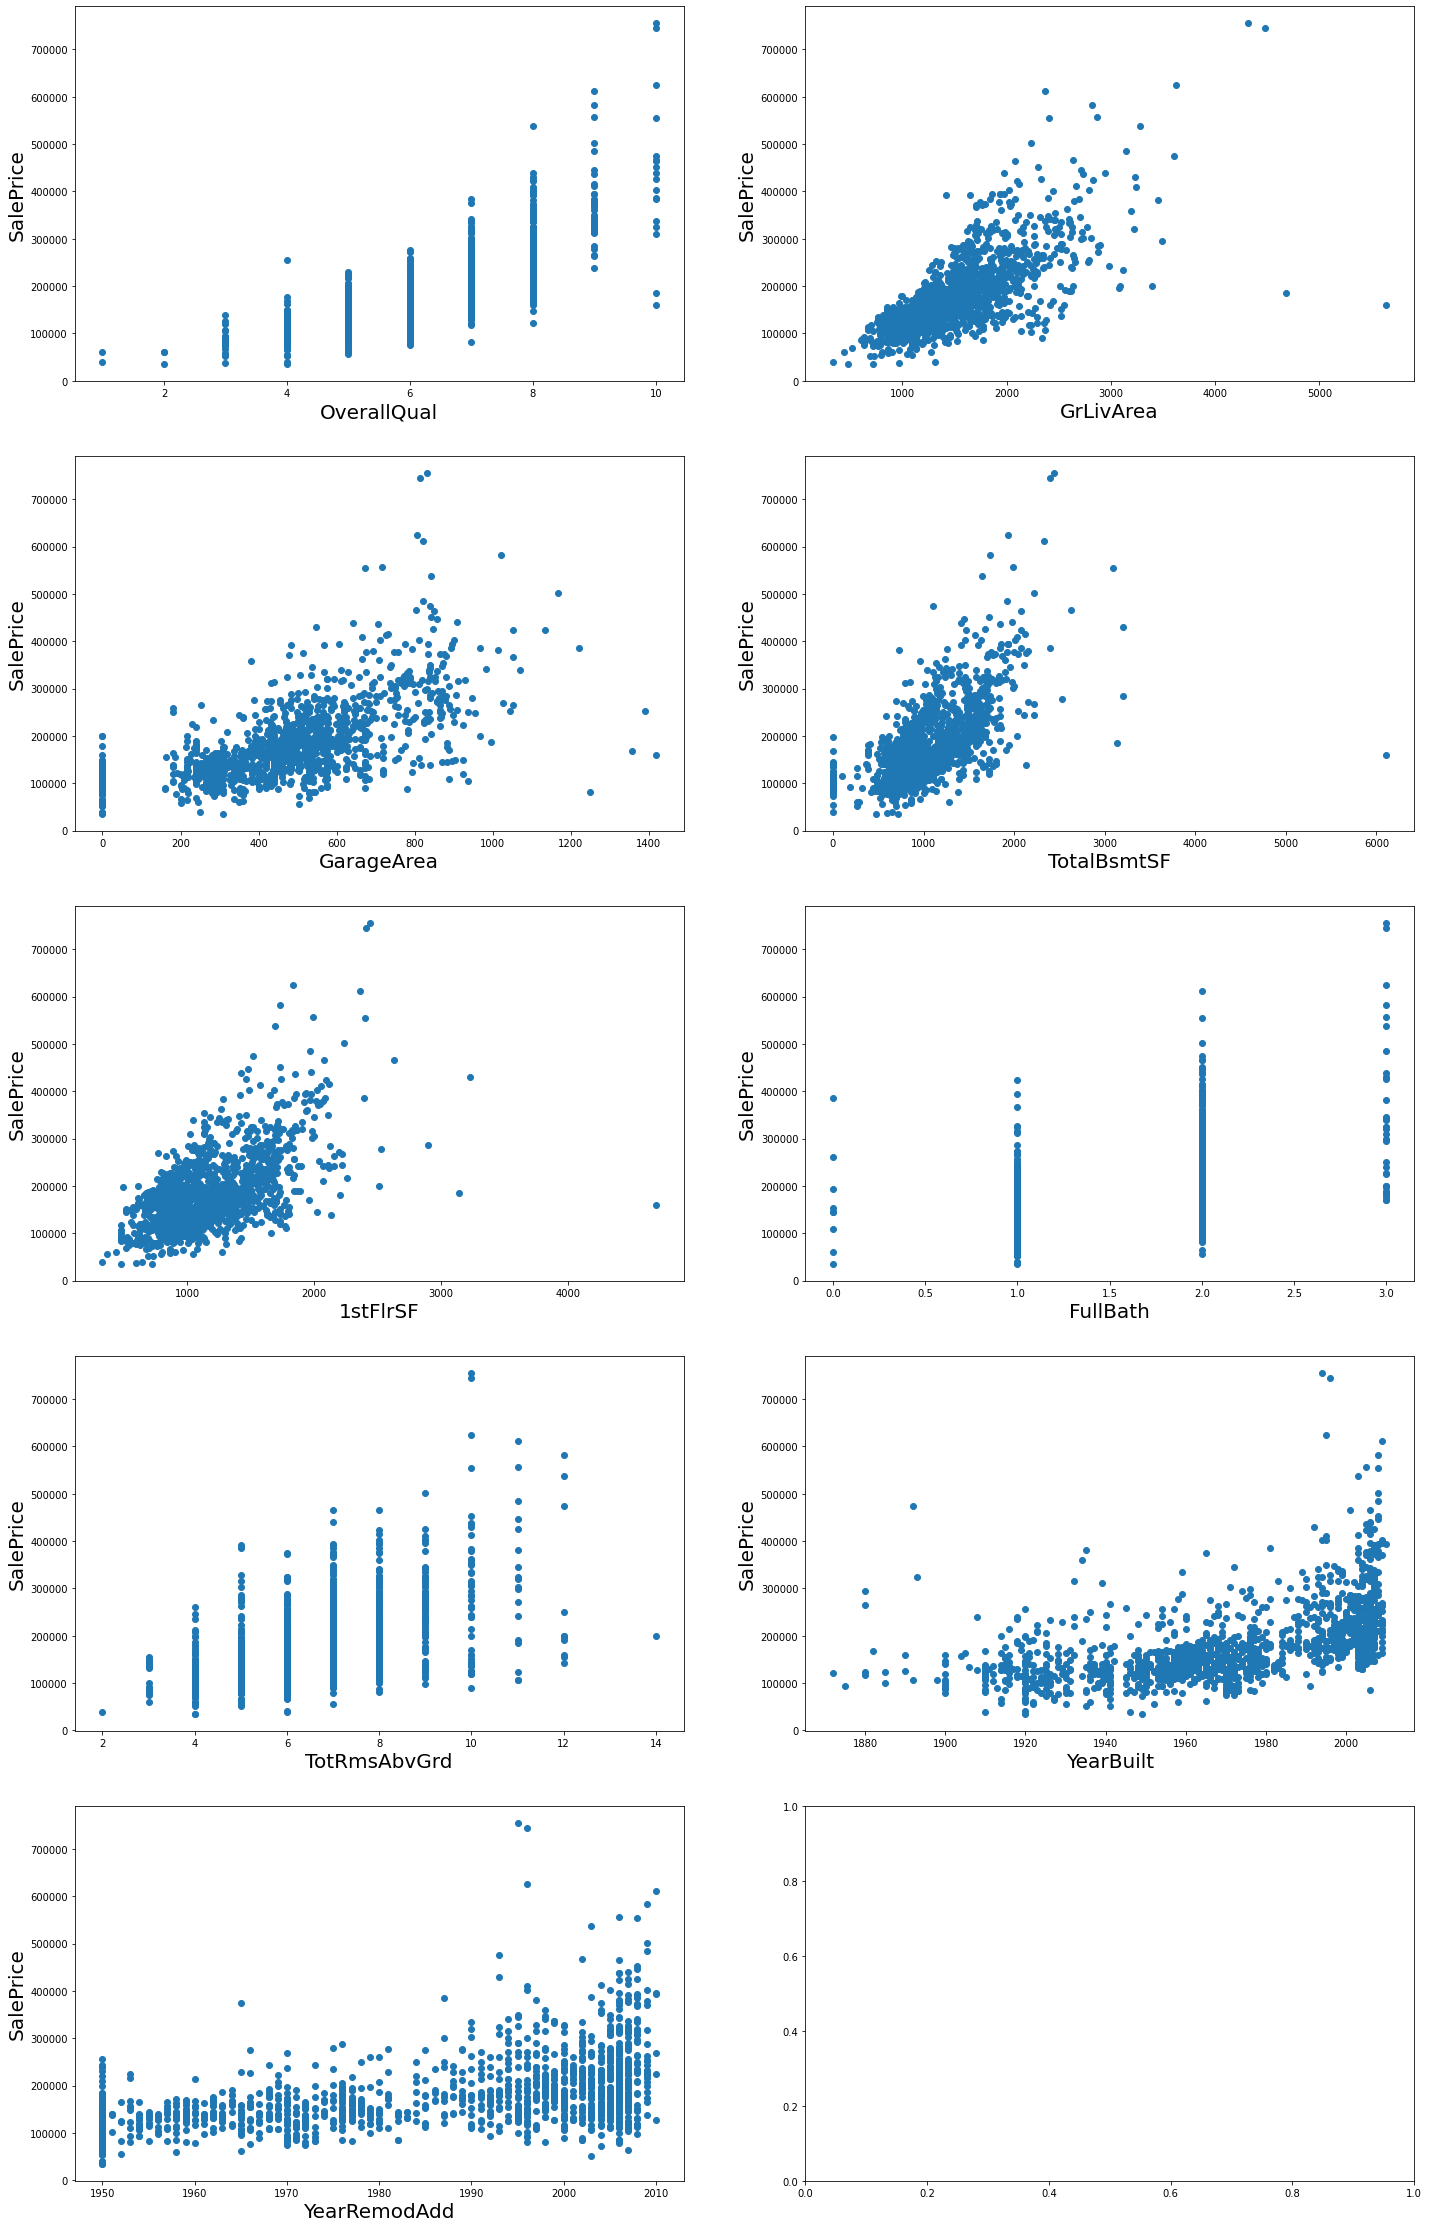

In [16]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5,2, figsize =(24,40))

ax1.set_xlabel('OverallQual', fontsize=20)
ax1.set_ylabel('SalePrice', fontsize=20)
ax2.set_xlabel('GrLivArea', fontsize=20)
ax2.set_ylabel('SalePrice', fontsize=20)
ax3.set_xlabel('GarageArea', fontsize=20)
ax3.set_ylabel('SalePrice', fontsize=20)
ax4.set_xlabel('TotalBsmtSF', fontsize=20)
ax4.set_ylabel('SalePrice', fontsize=20)
ax5.set_xlabel('1stFlrSF', fontsize=20)
ax5.set_ylabel('SalePrice', fontsize=20)
ax6.set_xlabel('FullBath', fontsize=20)
ax6.set_ylabel('SalePrice', fontsize=20)
ax7.set_xlabel('TotRmsAbvGrd', fontsize=20)
ax7.set_ylabel('SalePrice', fontsize=20)
ax8.set_xlabel('YearBuilt', fontsize=20)
ax8.set_ylabel('SalePrice', fontsize=20)
ax9.set_xlabel('YearRemodAdd', fontsize=20)
ax9.set_ylabel('SalePrice', fontsize=20)


Y = df_train['SalePrice']
X1 = df_train['OverallQual']
X2 = df_train['GrLivArea']
X3 = df_train['GarageArea']
X4 = df_train['TotalBsmtSF']
X5 = df_train['1stFlrSF']
X6 = df_train['FullBath']
X7 = df_train['TotRmsAbvGrd']
X8 = df_train['YearBuilt']
X9 = df_train['YearRemodAdd']


ax1.scatter(X1, Y)
ax2.scatter(X2, Y)
ax3.scatter(X3, Y)
ax4.scatter(X4, Y)
ax5.scatter(X5, Y)
ax6.scatter(X6, Y)
ax7.scatter(X7, Y)
ax8.scatter(X8, Y)
ax9.scatter(X9, Y)

Based on the above we can drop a few more variables with lower correlation: YearRemodAdd, YearBuilt, TotRmsAbvGrd, FullBath. Since we know every other variable below YearRemodAdd has lower correlation, we can focus on the following variables:
- SalePrice
- OverallQual
- GrLivArea
- GarageArea
- TotalBsmtSF
- 1stFlrSF

As stated before, most of the variables are related to area.  

In [17]:
df_train.drop(df_train.columns.difference(['SalePrice','OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF'])
        , 1, inplace=True)
display(df_train)

,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea,SalePrice
0,7,856,856,1710,548,208500
1,6,1262,1262,1262,460,181500
2,7,920,920,1786,608,223500
3,7,756,961,1717,642,140000
4,8,1145,1145,2198,836,250000
...,...,...,...,...,...,...
1455,6,953,953,1647,460,175000
1456,6,1542,2073,2073,500,210000
1457,7,1152,1188,2340,252,266500
1458,5,1078,1078,1078,240,142125


## 4. Filter data

Now that we have our final list of explanatory variables the next step is to filter the data. Specifically we want to detect and remove outliers. To do so, lets standardize our sales price to establish a threshold for outliers. We expect the mean to be 0 with a standard deviation of 1.

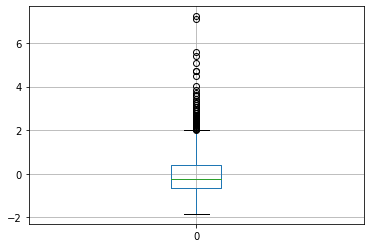

In [18]:
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
sale_std = pd.DataFrame(saleprice_scaled)
bp = sale_std.boxplot() 

# low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
# high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
# print('outer range (low) of the distribution:')
# print(low_range)
# print('\nouter range (high) of the distribution:')
# print(high_range)

We see in the boxplot that we have quite a few upper outliers. This tells us that house prices are prone to more expensive exceptions and we shouldn't be expecting any cheaper exceptions.

Regardless, we need to remove any outliers before creating our model. Take a loot at the scatter plot below:

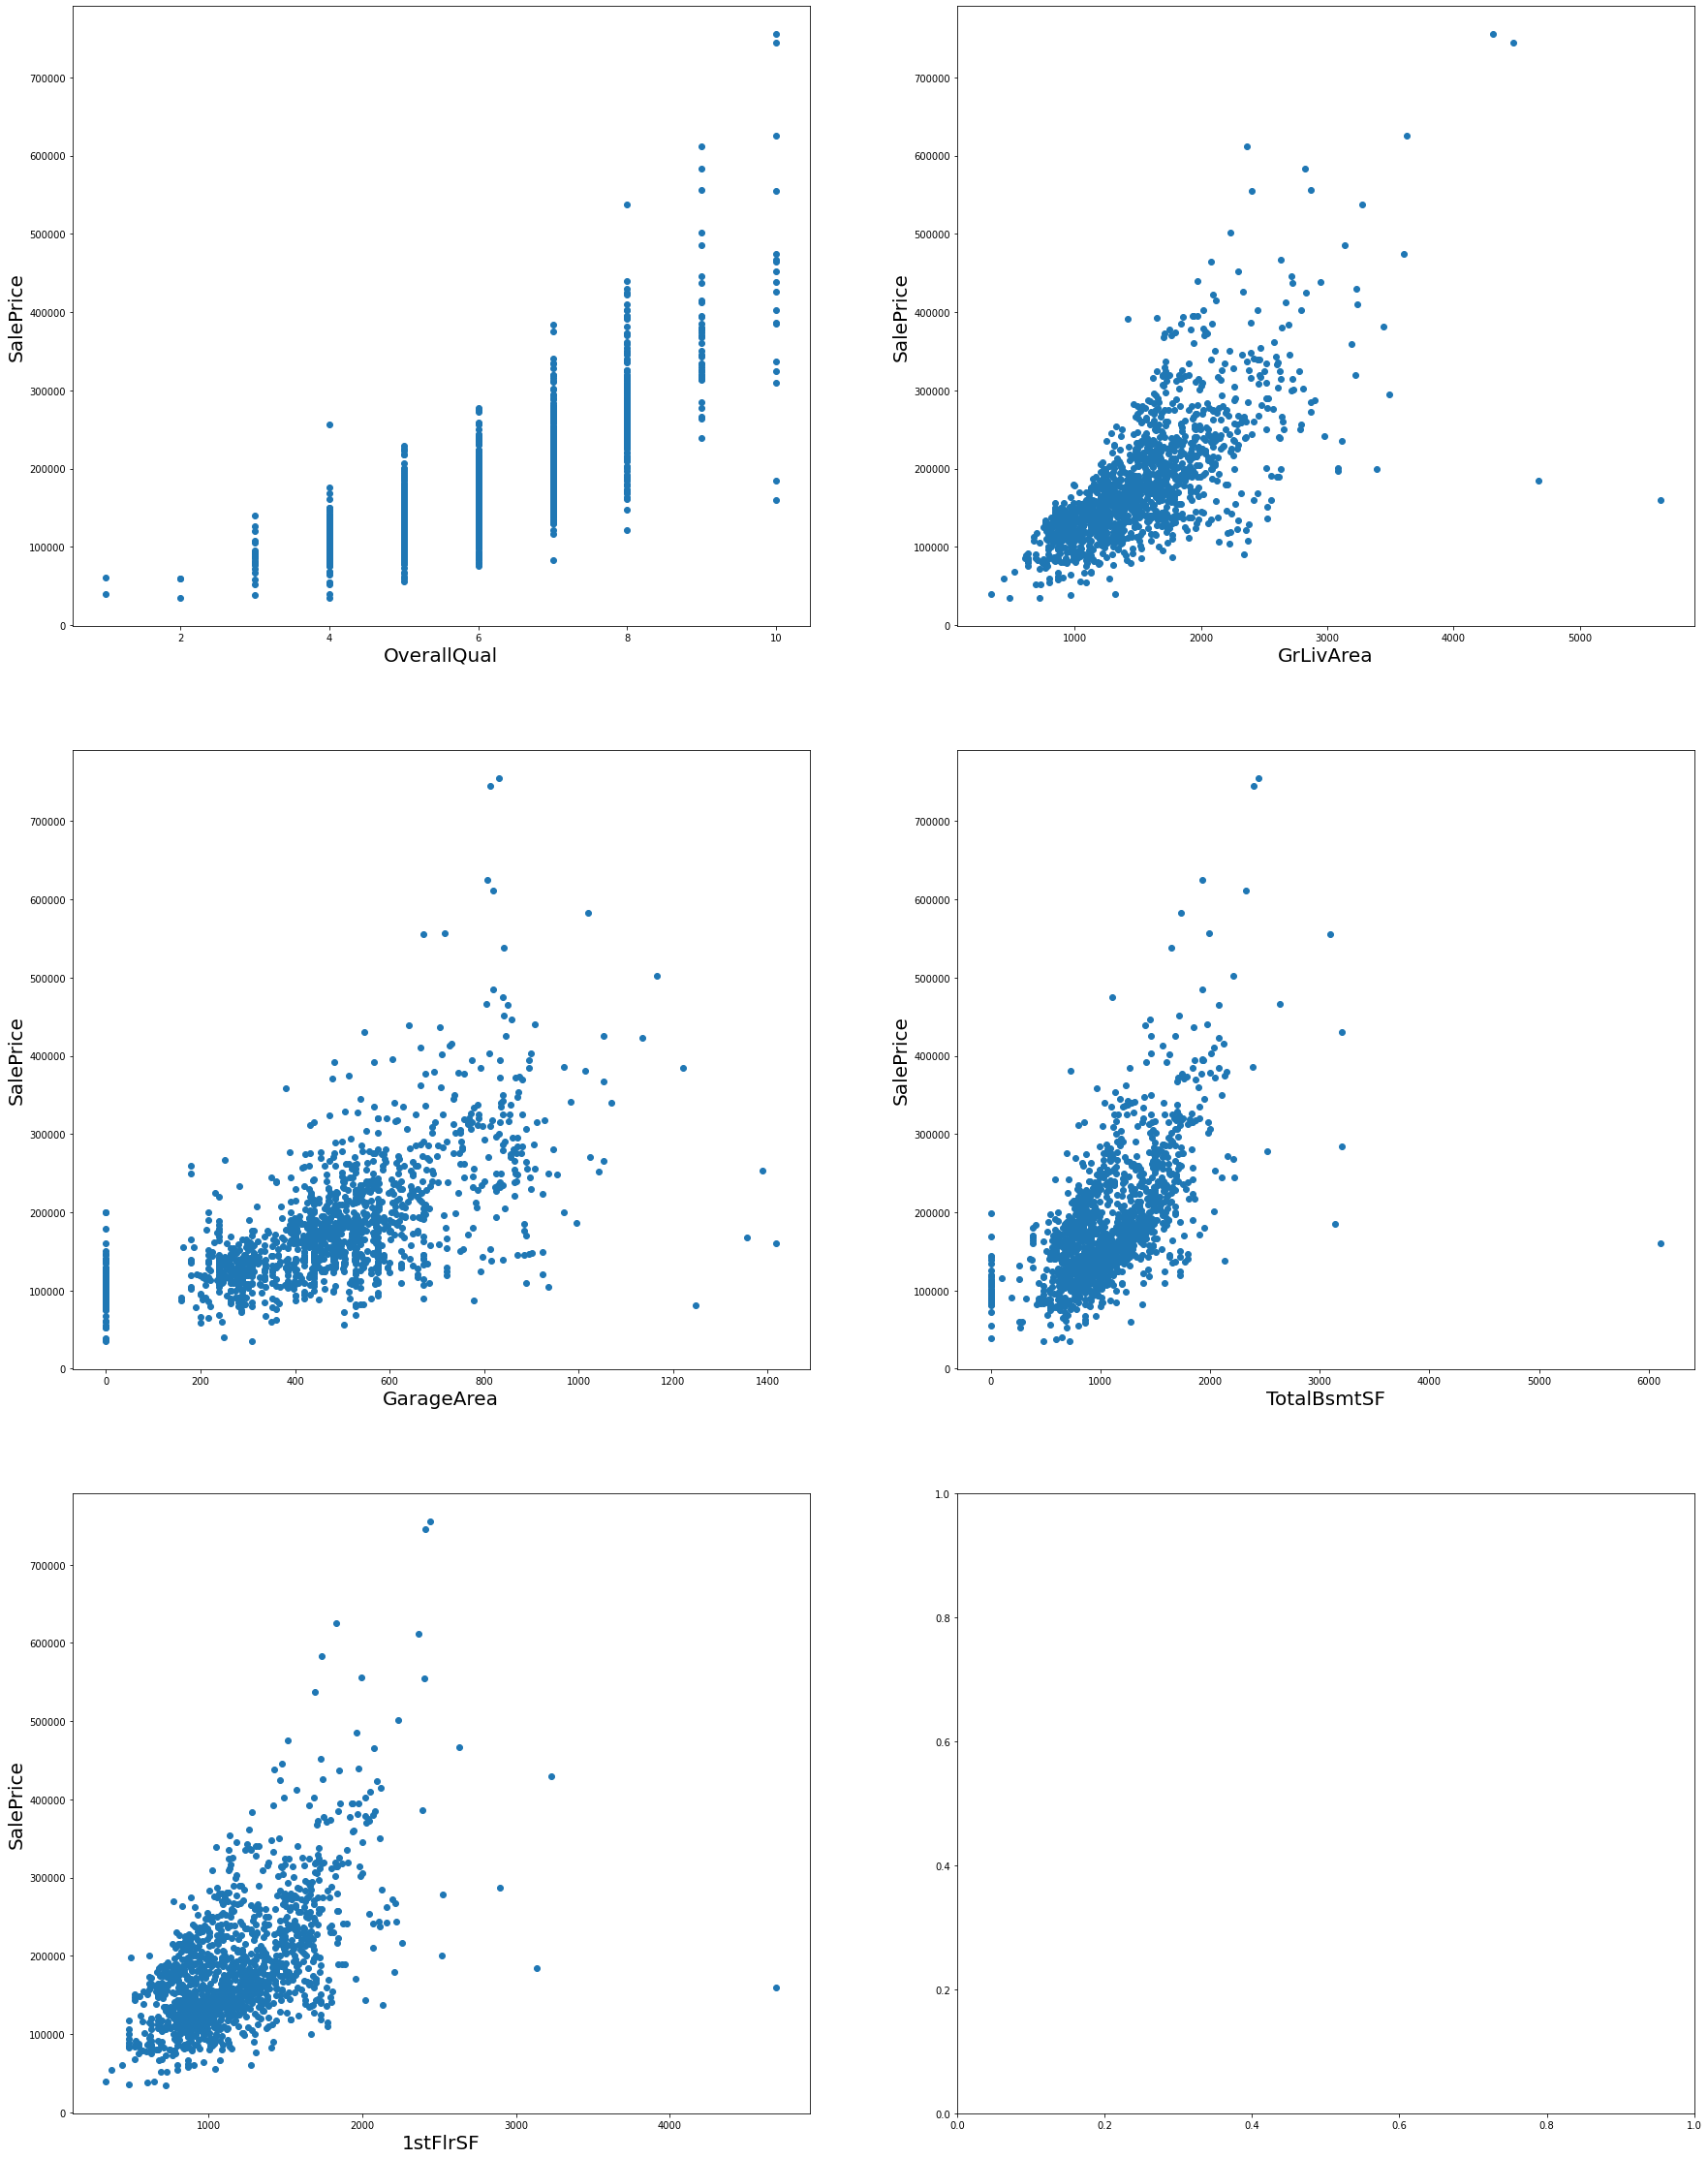

In [19]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize =(30,40))

ax1.set_xlabel('OverallQual', fontsize=20)
ax1.set_ylabel('SalePrice', fontsize=20)
ax2.set_xlabel('GrLivArea', fontsize=20)
ax2.set_ylabel('SalePrice', fontsize=20)
ax3.set_xlabel('GarageArea', fontsize=20)
ax3.set_ylabel('SalePrice', fontsize=20)
ax4.set_xlabel('TotalBsmtSF', fontsize=20)
ax4.set_ylabel('SalePrice', fontsize=20)
ax5.set_xlabel('1stFlrSF', fontsize=20)
ax5.set_ylabel('SalePrice', fontsize=20)


Y = df_train['SalePrice']
X1 = df_train['OverallQual']
X2 = df_train['GrLivArea']
X3 = df_train['GarageArea']
X4 = df_train['TotalBsmtSF']
X5 = df_train['1stFlrSF']


ax1.scatter(X1, Y)
ax2.scatter(X2, Y)
ax3.scatter(X3, Y)
ax4.scatter(X4, Y)
ax5.scatter(X5, Y)

There are potential outliers that catch our eyes. To systematically detect and remove outliers we can:
1. Compute the Z-score of each value in the column, relative to the column mean and standard deviation
2. Get absolute value of the Z-score and check if it's below the threshold
3. Check whether all rows each column satisfy this condition (below threshold)
4. Result of this condition is used to index the dataframe.

In most large data sets, 99% of values have a Z-score between -3 and 3, meaning they lie within three standard deviations above and below the mean. Therefore we can set the condition for the absolute Z-score to be lower than 3


In [20]:
df_train_std = df_train[(np.abs(stats.zscore(df_train)) < 3).all(axis=1)]

Let's see the scatter plot again. This time we set the x and y axis limit to be the same as above for visual comparison.

(0.0, 700000.0)

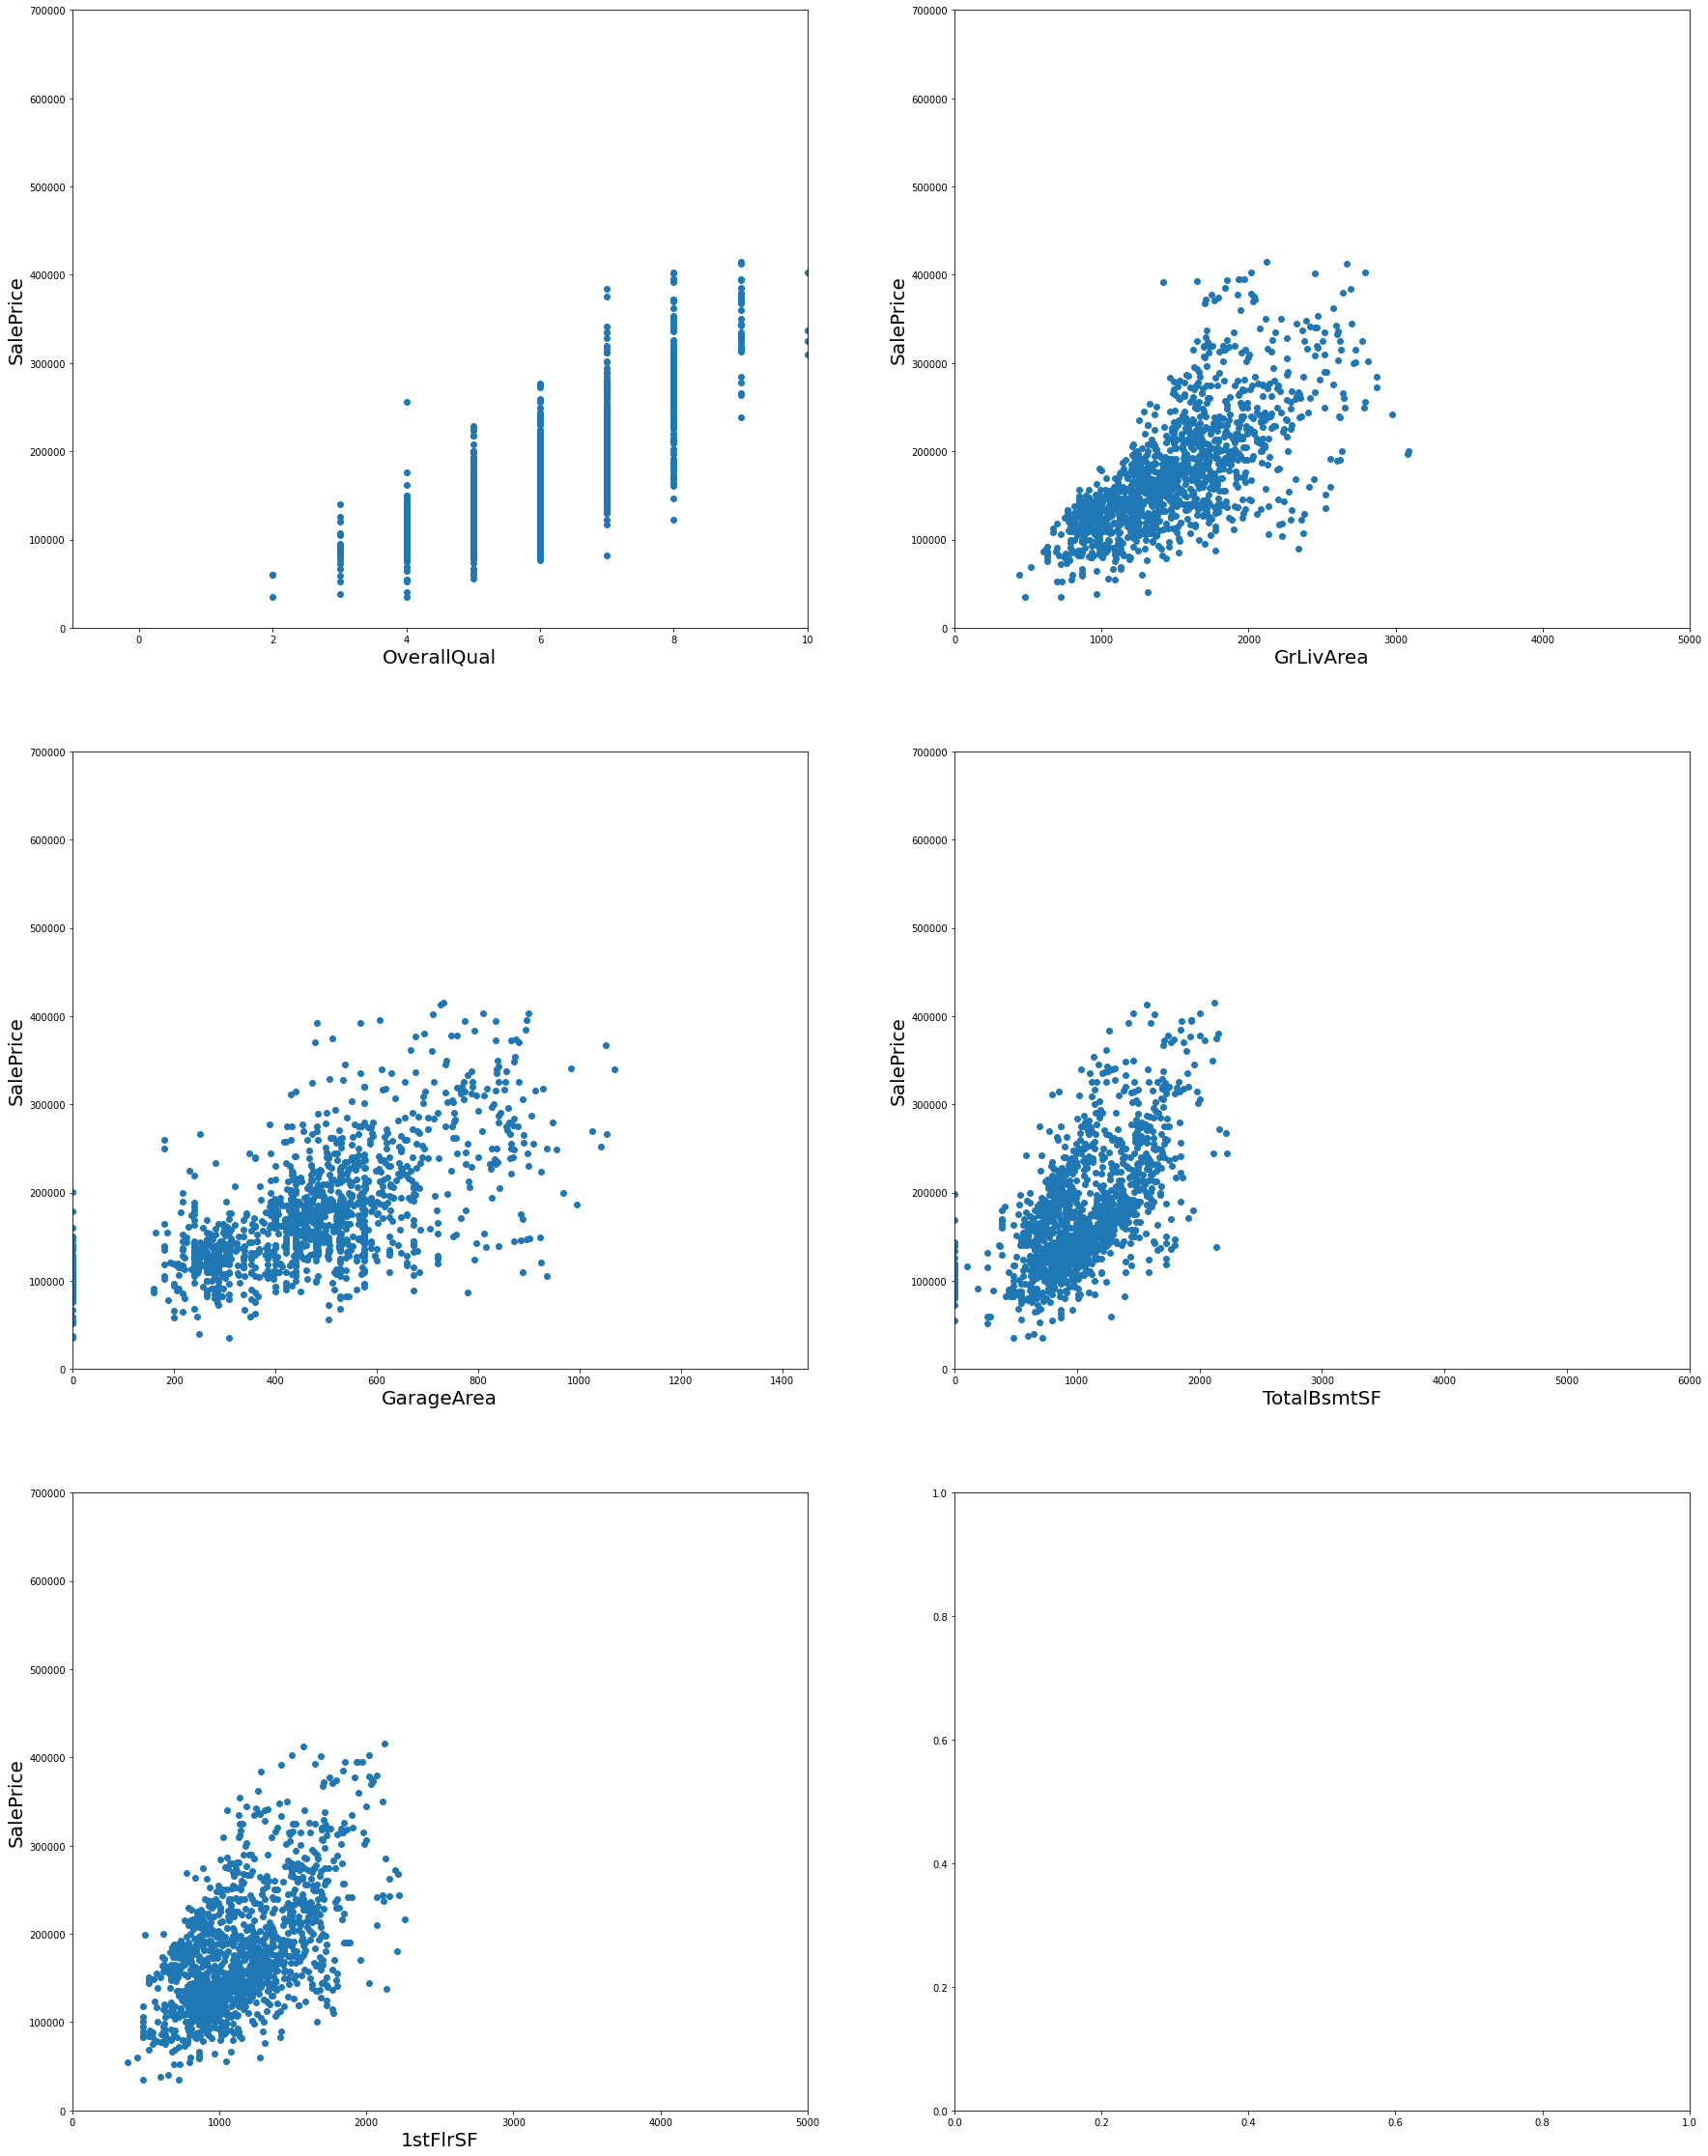

In [21]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize =(30,40))

ax1.set_xlabel('OverallQual', fontsize=20)
ax1.set_ylabel('SalePrice', fontsize=20)
ax2.set_xlabel('GrLivArea', fontsize=20)
ax2.set_ylabel('SalePrice', fontsize=20)
ax3.set_xlabel('GarageArea', fontsize=20)
ax3.set_ylabel('SalePrice', fontsize=20)
ax4.set_xlabel('TotalBsmtSF', fontsize=20)
ax4.set_ylabel('SalePrice', fontsize=20)
ax5.set_xlabel('1stFlrSF', fontsize=20)
ax5.set_ylabel('SalePrice', fontsize=20)


Y = df_train_std['SalePrice']
X1 = df_train_std['OverallQual']
X2 = df_train_std['GrLivArea']
X3 = df_train_std['GarageArea']
X4 = df_train_std['TotalBsmtSF']
X5 = df_train_std['1stFlrSF']

ax1.scatter(X1, Y)
ax2.scatter(X2, Y)
ax3.scatter(X3, Y)
ax4.scatter(X4, Y)
ax5.scatter(X5, Y)

ax1.set_xlim((-1, 10))
ax1.set_ylim((0, 700000))
ax2.set_xlim((-1, 5000))
ax2.set_ylim((0, 700000))
ax3.set_xlim((-1, 1450))
ax3.set_ylim((0, 700000))
ax4.set_xlim((-1, 6000))
ax4.set_ylim((0, 700000))
ax5.set_xlim((-1, 5000))
ax5.set_ylim((0, 700000))


## 5. Normalize data

### Data transformation
Now that we have our filtered data set, it is time to create our regression model. Before that we should normalize our dataset(i.e. transform the each of our variables to display normal distribution). While this is not always necessary (as in this case) we will create a normalized dataset and non-normalized dataset and compare the difference of our model performance. But many times normalizing is essential as many models are calculated under the assumption that it derives from a normal distribution. 

We plot the distribution functions of each 6 variables. Since one of the variable is a discrete dataset, we perform 5 normalization. If the distribution function shows positive skewedness, we do log transformation. If it shows negative skewedness, we do exponential transformation.

Some things to be aware:
- the above technique only works for continous datasets. 
- for clarity we will create a new column for each normalized data
- after transforming the data the result could be inf

The dependent variable 'SalePrice':

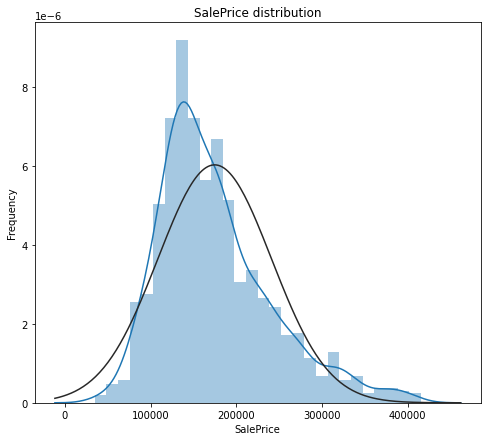

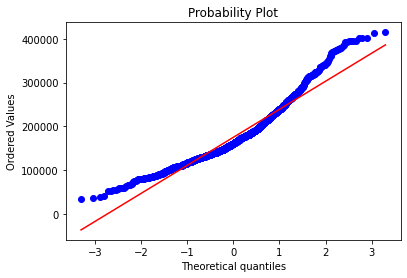

In [22]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.distplot(df_train_std['SalePrice'], fit=norm);
ax.set_xlabel('SalePrice')
ax.set_ylabel('Frequency')
ax.set(title="SalePrice distribution")
# below necessary
fig = plt.figure()
res = stats.probplot(df_train_std['SalePrice'], plot=plt)

Since current 'SalePrice' distribution does not resemble a normal distribution and is positively skewed, we do log transformation.

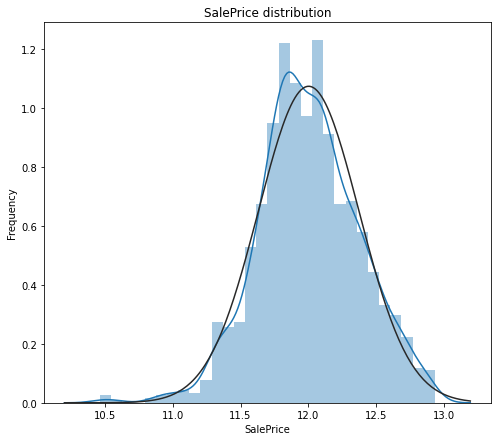

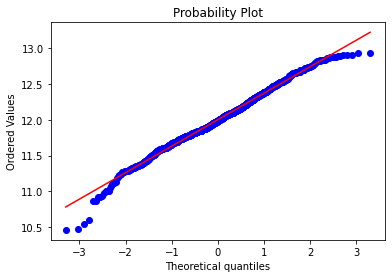

In [23]:
df_train_std['SalePriceNorm'] = np.log(df_train_std['SalePrice'])

fig, ax = plt.subplots(figsize=(8, 7))
sns.distplot(df_train_std['SalePriceNorm'], fit=norm);
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
fig = plt.figure()
res = stats.probplot(df_train_std['SalePriceNorm'], plot=plt)


Now we do the same for the others:

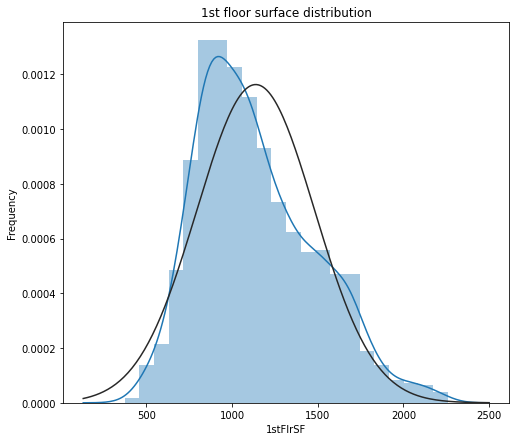

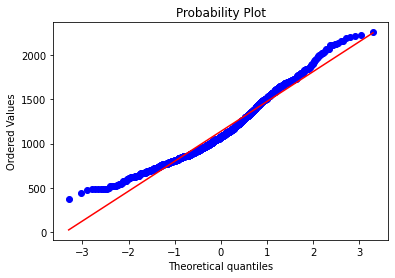

In [24]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.distplot(df_train_std['1stFlrSF'], fit=norm);
ax.set_xlabel('1stFlrSF')
ax.set_ylabel('Frequency')
ax.set(title="1st floor surface distribution")
fig = plt.figure()
res = stats.probplot(df_train_std['1stFlrSF'], plot=plt)

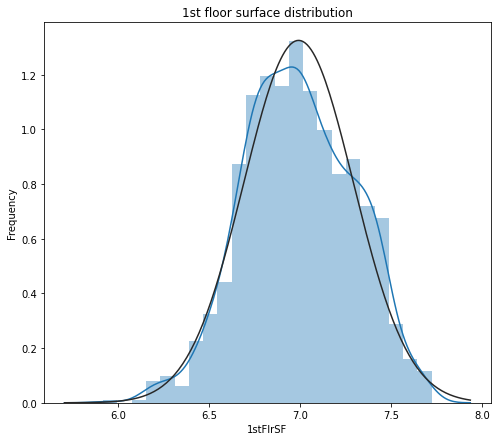

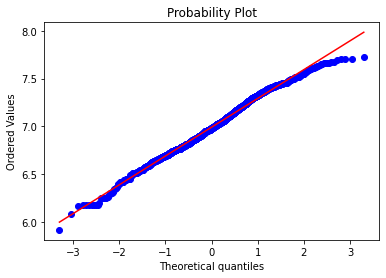

In [25]:
df_train_std['1stFlrSFNorm'] = np.log(df_train_std['1stFlrSF'])

fig, ax = plt.subplots(figsize=(8, 7))
sns.distplot(df_train_std['1stFlrSFNorm'], fit=norm);
ax.set_xlabel('1stFlrSF')
ax.set_ylabel('Frequency')
ax.set(title="1st floor surface distribution")
fig = plt.figure()
res = stats.probplot(df_train_std['1stFlrSFNorm'], plot=plt)

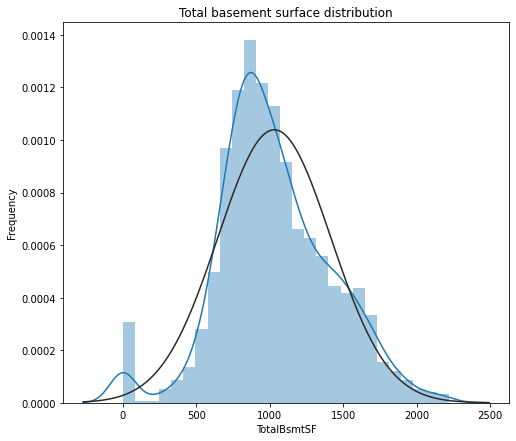

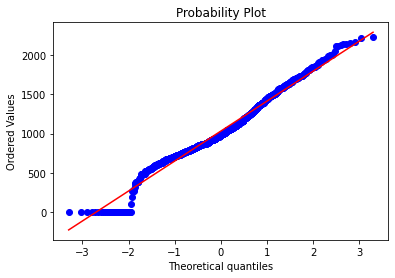

In [26]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.distplot(df_train_std['TotalBsmtSF'], fit=norm);
ax.set_xlabel('TotalBsmtSF')
ax.set_ylabel('Frequency')
ax.set(title="Total basement surface distribution")
fig = plt.figure()
res = stats.probplot(df_train_std['TotalBsmtSF'], plot=plt)

The variable 'TotalBsmtSF' will contain some inf values after transforming. We will replace them with NaN values and then perform imputation like we did earlier with the mean value.

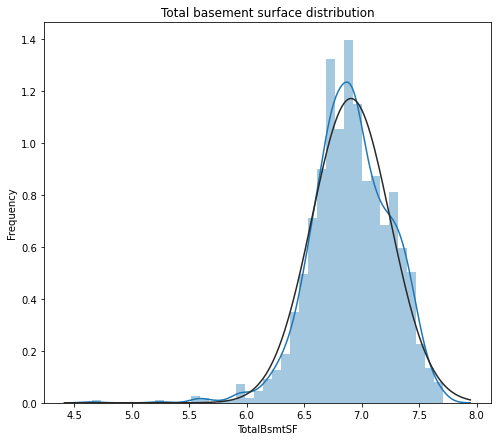

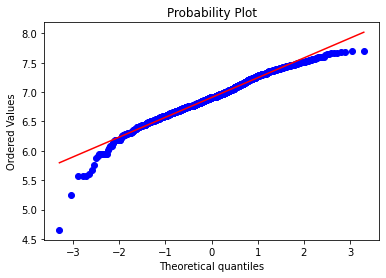

In [27]:
fig, ax = plt.subplots(figsize=(8, 7))
df_train_std['TotalBsmtSFNorm'] = np.log(df_train_std['TotalBsmtSF'])

# replace inf values with NaN and then perform imputation
si = SimpleImputer(missing_values=np.nan, strategy='mean')
df_train_std['TotalBsmtSFNorm'].replace([np.inf, -np.inf], np.nan, inplace=True)
si.fit(df_train_std[['TotalBsmtSFNorm']])
df_train_std['TotalBsmtSFNorm'] = si.transform(df_train_std[['TotalBsmtSFNorm']])

sns.distplot(df_train_std['TotalBsmtSFNorm'], fit=norm);
ax.set_xlabel('TotalBsmtSF')
ax.set_ylabel('Frequency')
ax.set(title="Total basement surface distribution")
fig = plt.figure()

res = stats.probplot(df_train_std['TotalBsmtSFNorm'], plot=plt)

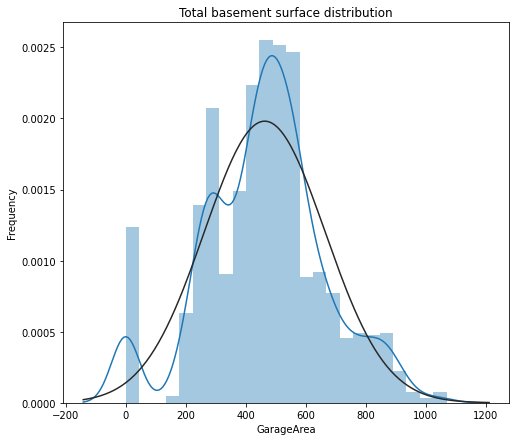

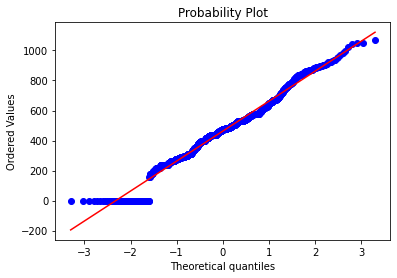

In [28]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.distplot(df_train_std['GarageArea'], fit=norm);
ax.set_xlabel('GarageArea')
ax.set_ylabel('Frequency')
ax.set(title="Total basement surface distribution")
fig = plt.figure()
res = stats.probplot(df_train_std['GarageArea'], plot=plt)

The 'GarageArea' column will also contain inf float values thus we have to replace them with NaN and perform imputation as well.

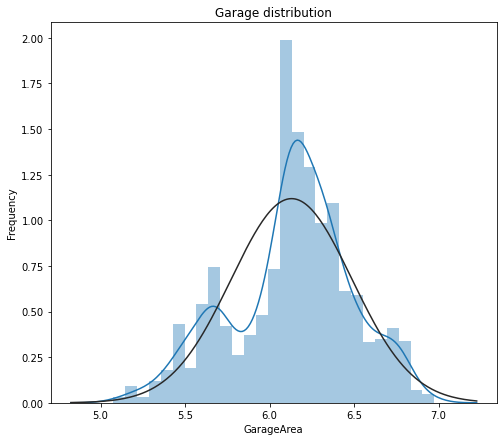

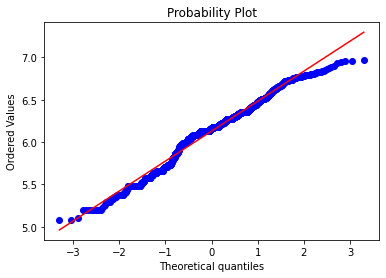

In [29]:
fig, ax = plt.subplots(figsize=(8, 7))
df_train_std['GarageAreaNorm'] = np.log(df_train_std['GarageArea'])

# replace inf values with NaN and then perform imputation
df_train_std['GarageAreaNorm'].replace([np.inf, -np.inf], np.nan, inplace=True)
si.fit(df_train_std[['GarageAreaNorm']])
df_train_std['GarageAreaNorm'] = si.transform(df_train_std[['GarageAreaNorm']])

sns.distplot(df_train_std['GarageAreaNorm'], fit=norm);
ax.set_xlabel('GarageArea')
ax.set_ylabel('Frequency')
ax.set(title="Garage distribution")
fig = plt.figure()
res = stats.probplot(df_train_std['GarageAreaNorm'], plot=plt)

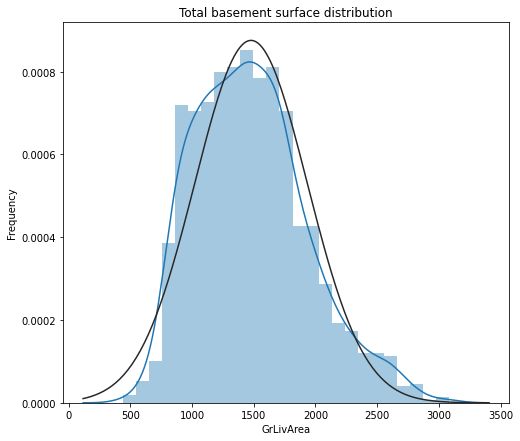

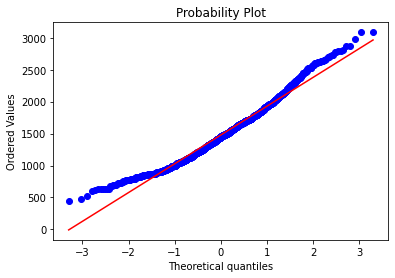

In [30]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.distplot(df_train_std['GrLivArea'], fit=norm);
ax.set_xlabel('GrLivArea')
ax.set_ylabel('Frequency')
ax.set(title="Total basement surface distribution")
fig = plt.figure()
res = stats.probplot(df_train_std['GrLivArea'], plot=plt)

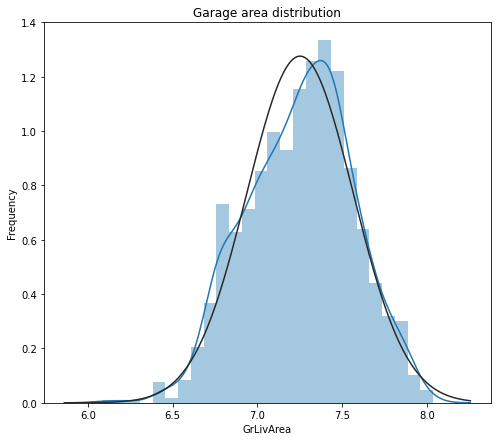

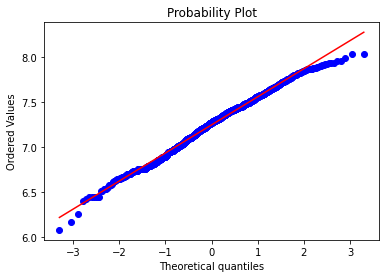

In [31]:
df_train_std['GrLivAreaNorm'] = np.log(df_train_std['GrLivArea'])

fig, ax = plt.subplots(figsize=(8, 7))
sns.distplot(df_train_std['GrLivAreaNorm'], fit=norm);
ax.set_xlabel('GrLivArea')
ax.set_ylabel('Frequency')
ax.set(title="Garage area distribution")
fig = plt.figure()
res = stats.probplot(df_train_std['GrLivAreaNorm'], plot=plt)

The final variable 'OverallQual' is a discrete dataset, thus we can't normalize it. However, it already has a normal distribution so problem solved.

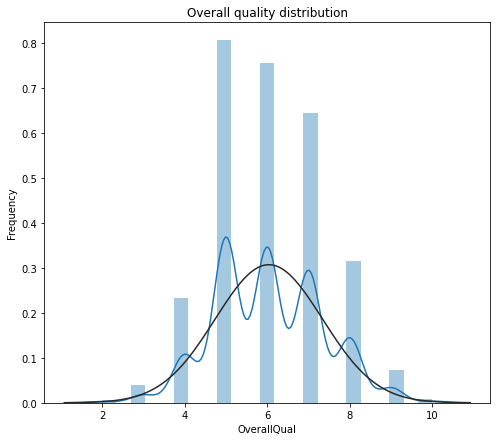

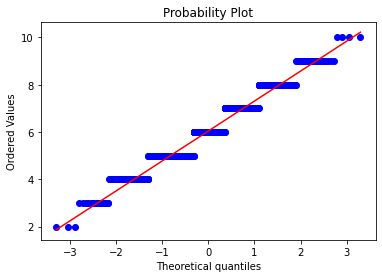

In [32]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.distplot(df_train_std['OverallQual'], fit=norm);
ax.set_xlabel('OverallQual')
ax.set_ylabel('Frequency')
ax.set(title="Overall quality distribution")
fig = plt.figure()
res = stats.probplot(df_train_std['OverallQual'], plot=plt)

# 6. Training and validating models

We can now start creating and training our model. There are several options to choose from so we will start off with a simple one. The general rule of thumb is dividing up your dataset so that 80% is used to train and 20% is used to test your model. 

Later on we will be using k-fold cross validation. This means that we will take 20% of our dataset from different sections 5 times and a set of 5 different parameters for our coefficients. We will test these parameters and choose the best one to be our linear regression model

### 6.1 Linear regression
Lucky for us all of our variables follow a simple linear regression thus we can be confident that a linear regression model will yield sufficient results.

In addition, we will create infrastructure so that it will be easier to perform k-cross validation

In [147]:
k = int(np.round(len(df_train_std)/5))


# will return an array of dataframes; first is training set, next is the testing set
# indicate start and end of test dataframe indices, not train dataframe
def train_and_test_dataframe(start, end, dataframe):
    dataframe_test = dataframe.iloc[start:end]
    if start != 0 and end == len(dataframe):
        dataframe_train = dataframe.iloc[:start]
    elif start != 0:
        dataframe_train_1 = dataframe.iloc[:start]
        dataframe_train_2 = dataframe.iloc[end:]
        dataframe_train = pd.concat([dataframe_train_1, dataframe_train_2], ignore_index=False)
    else:
        dataframe_train = dataframe.iloc[end:]
    return [dataframe_train, dataframe_test]


k1 = train_and_test_dataframe(0, k, df_train_std)
k2 = train_and_test_dataframe(k, 2*k, df_train_std)
k3 = train_and_test_dataframe(2*k, 3*k, df_train_std)
k4 = train_and_test_dataframe(3*k, 4*k, df_train_std)
k5 = train_and_test_dataframe(4*k, len(df_train_std), df_train_std)

Now to compute our parameters and train our model using the 5 separated datasets

In [152]:
# pass the training dataframe, thus first item in array of our k variables
# returns an array of corresponding variables/columns for training model
def compute_variables(k):    
    # the normalized dataset
#     X1_train = k['OverallQual']
#     X2_train = k['GrLivAreaNorm']
#     X3_train = k['GarageAreaNorm']
#     X4_train = k['TotalBsmtSFNorm']
#     X5_train = k['1stFlrSFNorm']
#     Y_train = k['SalePriceNorm']

    X1_train = k['OverallQual']
    X2_train = k['GrLivArea']
    X3_train = k['GarageArea']
    X4_train = k['TotalBsmtSF']
    X5_train = k['1stFlrSF']
    Y_train = k['SalePrice']
    return [X1_train, X2_train, X3_train, X4_train, X5_train, Y_train]


# computes the model result
def compute_results(var):
    design_matrix = np.c_[np.ones(len(var[0])), var[0], var[1], var[2], var[3], var[4]]
    model = smreg.linear_model.OLS(var[5], design_matrix)
    return model.fit()


# computes the y_hat
# equation y=β0+β1x1+β2x2+β3x3+β4x4+β5x5
def compute_y_hat(result, var):
    params = result.params
    return params[0] + var[0]*params[1] + var[1]*params[2] + var[2]*params[3] + var[3]*params[4] + var[4]*params[5]
    

var_train_1 = compute_variables(k1[0])
var_train_2 = compute_variables(k2[0])
var_train_3 = compute_variables(k3[0])
var_train_4 = compute_variables(k4[0])
var_train_5 = compute_variables(k5[0])

results1 = compute_results(var_train_1)
results2 = compute_results(var_train_2)
results3 = compute_results(var_train_3)
results4 = compute_results(var_train_4)
results5 = compute_results(var_train_5)

y_hat_1 = compute_y_hat(results1, var_train_1)
y_hat_2 = compute_y_hat(results2, var_train_2)
y_hat_3 = compute_y_hat(results3, var_train_3)
y_hat_4 = compute_y_hat(results4, var_train_4)
y_hat_5 = compute_y_hat(results5, var_train_5)

Now we will compute the R squared of each y_hat and choose the most efficient one to be our linear regression model

In [153]:
print(f"R-squared of y hat 1: {results1.rsquared}")
print(f"R-squared of y hat 2: {results2.rsquared}")
print(f"R-squared of y hat 3: {results3.rsquared}")
print(f"R-squared of y hat 4: {results4.rsquared}")
print(f"R-squared of y hat 5: {results5.rsquared}")

R-squared of y hat 1: 0.804216344572142
R-squared of y hat 2: 0.7889073083016803
R-squared of y hat 3: 0.8046247374590099
R-squared of y hat 4: 0.8037082257113493
R-squared of y hat 5: 0.807171413211808


The r-squared of each k are pretty close to each other but the last k seems to be the most efficient so we will choose this for our linear regression model.

### 6.1 Random forest

# 7. Testing models

Now that we have selected our model, we should test it from this kth validation. If we were to use a separate test dataset, we would have to apply the same normalization techniques we did with our training dataset(if we applied scaling, then also the exact same scaling).

### 7.1 Linear regression model

We will reuse some of the methods we have defined in the previous section

In [140]:
# computing 
var_test_5 = compute_variables(k5[1])
result_test = compute_results(var_test_5)
y_hat_test = compute_y_hat(result_test, var_test_5)

# fig, ax = plt.subplots(figsize=(16, 8))

# k = len(var_test_5[5])
# barwidth = 0.35
# br1 = np.arange(k)
# br2 = [x + barwidth for x in br1]
# plt.bar(br1, var_test_5[5], color='g', width=barwidth, label="Actual sale price")
# plt.bar(br2, y_hat_test, color='b', width=barwidth, label="Projected sale price")
# plt.ylabel("Sale price")
# plt.xlabel("House units")
# plt.legend()

Let's create a scatter plot of the projected sale price and actual sale price. We can check how well our model has done.

Text(0, 0.5, 'actual sale price')

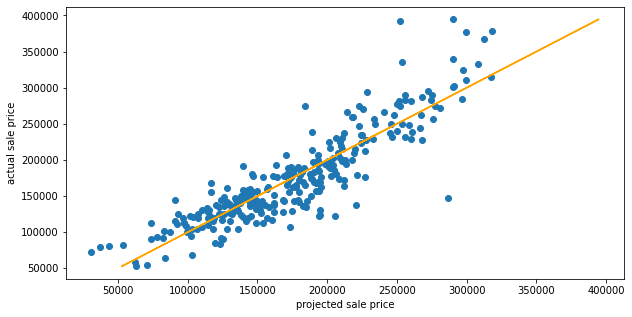

In [141]:
y_real = var_test_5[5]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(y_hat_test, y_real)
plt.plot(Y_test, Y_test, 'orange')
plt.xlabel('projected sale price')
plt.ylabel('actual sale price')

In addition we can perform additional accuracy checks with:
- R-squared
- RMSE or real mean squared error
- Residual plot

R-squared: 0.7900180683150995
RMSE: 29582.471654063676


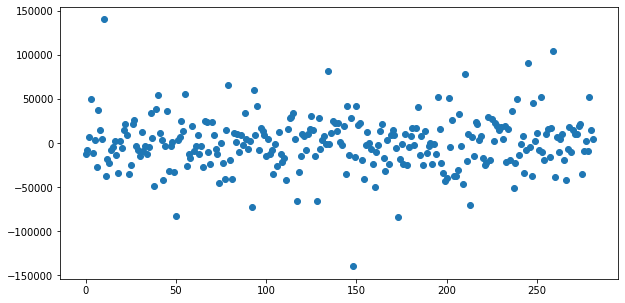

In [146]:
residual = y_real - y_hat_test
n = len(y_real)

def compute_rmse(residuals, n):
    squared_error = np.square(residuals)
    return np.sqrt(squared_error.sum() / n)


print(f"R-squared: {r2_score(y_real, y_hat_test)}")
print(f"RMSE: {compute_rmse(residual, n)}")


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(range(n), residual)

The r-squared of 0.79 is very close to what we got when computing the r-squared for our training dataset. In addition the RMSE of approximately 29600 dollars is not bad. Finally the residual scatter plot shows no distinct pattern or trend. When disregarding the outliers, we can assume this is an efficient model to predicting house sale prices.

### 7.2 Random forest


# 8. Projection
Now that we have selected our model, we can use it to project sale price of a house based on the same variables. Let's see a bar chart of the projected sale price and actual sale price. Keep in mind that since our model is based on normalizing and transforming the explanatory variables, the same computation should be done on our projection dataset

In [155]:
df_test = pd.read_csv("resources/test.csv")
df_test.drop(df_test.columns.difference(['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF'])
        , 1, inplace=True)

# Fix this part. This function tends to return an empty dataframe
# # remove outliers
# df_test_std = df_test[(np.abs(stats.zscore(df_test)) < 3).all(axis=1)]

df_test_std = df_test

# normalize data
df_test_std['1stFlrSFNorm'] = np.log(df_test_std['1stFlrSF'])
df_test_std['TotalBsmtSFNorm'] = np.log(df_test_std['TotalBsmtSF'])
df_test_std['GarageAreaNorm'] = np.log(df_test_std['GarageArea'])
df_test_std['GrLivAreaNorm'] = np.log(df_test_std['GrLivArea'])

# replace inf values by imputation
si = SimpleImputer(missing_values=np.nan, strategy='mean')
df_test_std['TotalBsmtSFNorm'].replace([np.inf, -np.inf], np.nan, inplace=True)
si.fit(df_test_std[['TotalBsmtSFNorm']])
df_test_std['TotalBsmtSFNorm'] = si.transform(df_test_std[['TotalBsmtSFNorm']])

df_test_std['GarageAreaNorm'].replace([np.inf, -np.inf], np.nan, inplace=True)
si.fit(df_train_std[['GarageAreaNorm']])
df_test_std['GarageAreaNorm'] = si.transform(df_test_std[['GarageAreaNorm']])

Now that we have the dataset, we can define our variables

In [158]:
# test dataset
x1 = df_test_std['OverallQual']
x2 = df_test_std['GrLivArea']
x3 = df_test_std['GarageArea']
x4 = df_test_std['TotalBsmtSF']
x5 = df_test_std['1stFlrSF']

# # the normalized test dataset
# x1 = df_test_std['OverallQual']
# x2 = df_test_std['GrLivAreaNorm']
# x3 = df_test_std['GarageAreaNorm']
# x4 = df_test_std['TotalBsmtSFNorm']
# x5 = df_test_std['1stFlrSFNorm']

projection = compute_y_hat(results5, [x1, x2, x3, x4, x5])

We will use these variables to check its distribution.

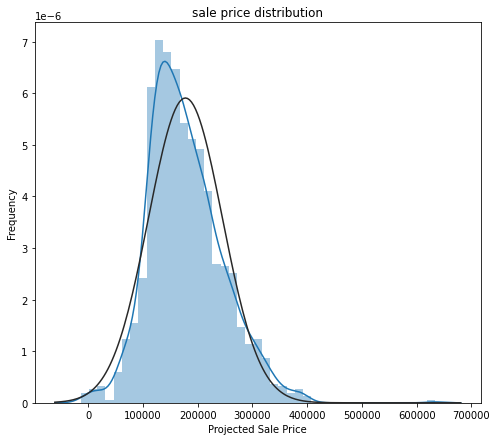

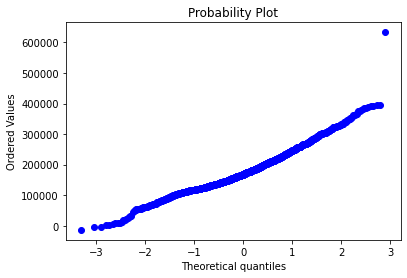

In [159]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.distplot(projection, fit=norm);
ax.set_xlabel('Projected Sale Price')
ax.set_ylabel('Frequency')
ax.set(title="sale price distribution")

fig = plt.figure()
res = stats.probplot(projection, plot=plt)